In [142]:
import os
import cv2

import zipfile

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import skimage.measure
from scipy.ndimage import convolve

print(cv2.__version__)  # my version is 3.4.1
print(os.getcwd())

folder = 'test'  
import pathlib
pathlib.Path(folder).mkdir(exist_ok=True)

3.4.1
/Users/nemishkanwar/OneDrive - Zinnov Management Consulting Private Limited/Projects/Github/walk_jog_classification/walk_or_jog_video_classification


### Unzip files to folder

In [22]:
if './signzy_data' not in [item[0] for item in os.walk('.')]:
    zip_ref = zipfile.ZipFile('signzy_data.zip', 'r')
    zip_ref.extractall('signzy_data')
    zip_ref.close()

In [25]:
for root, dirs, files in os.walk("./signzy_data/"):  
    for filename in files:
        print(root+'/'+filename)

./signzy_data/Data/Walking/person05_walking_d1_uncomp.avi
./signzy_data/Data/Walking/person02_walking_d2_uncomp.avi
./signzy_data/Data/Walking/person13_walking_d1_uncomp.avi
./signzy_data/Data/Walking/person09_walking_d3_uncomp.avi
./signzy_data/Data/Walking/person11_walking_d4_uncomp.avi
./signzy_data/Data/Walking/person01_walking_d3_uncomp.avi
./signzy_data/Data/Walking/person07_walking_d4_uncomp.avi
./signzy_data/Data/Walking/person07_walking_d1_uncomp.avi
./signzy_data/Data/Walking/person11_walking_d1_uncomp.avi
./signzy_data/Data/Walking/person03_walking_d3_uncomp.avi
./signzy_data/Data/Walking/person05_walking_d4_uncomp.avi
./signzy_data/Data/Walking/person08_walking_d2_uncomp.avi
./signzy_data/Data/Walking/person09_walking_d1_uncomp.avi
./signzy_data/Data/Walking/person05_walking_d3_uncomp.avi
./signzy_data/Data/Walking/person03_walking_d4_uncomp.avi
./signzy_data/Data/Walking/person13_walking_d3_uncomp.avi
./signzy_data/Data/Walking/person06_walking_d2_uncomp.avi
./signzy_data/

### Decompose video to individual frames

In [121]:
def decompose_video(x, folder=folder):
    '''
    decompose videos to series of bw image in test folder
    Input : video path, folder path
    '''
    file_name = x.split('/')
    vidcap = cv2.VideoCapture(x)
    success,image = vidcap.read()
    count = 0
    success = True
    count = 0
    while True:
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         print(file_name)
        cv2.imwrite(os.path.join(folder,file_name[-1].rstrip("_uncomp.avi")+"_frame{:d}.jpg".format(count)), img_gray)     # save frame as JPEG file
        success,image = vidcap.read()
        if not success:
            break

        count += 1
    print("{} images are extracted in {}.".format(count,folder))
    return file_name[-2]

In [124]:
decompose_video('./signzy_data/Data/Walking/person01_walking_d1_uncomp.avi')

554 images are extracted in test.


'Walking'

In [38]:
def list_to_array(x):
    '''
    Takes input of list of numpy arrays and converts to numpy array
    '''
    shape = list(x[0].shape)
    shape[:0] = [len(x)]
    arr = np.concatenate(x).reshape(shape)
    return arr

### identify all the person images

In [41]:
def get_video_matrix():
    temp_array = []
    indir = './test'
    for root, dirs, filenames in os.walk(indir):
        for f in filenames:
#             print(f)
            img=mpimg.imread(root+'/'+f)
            temp_array.append(img)
    video_array = list_to_array(temp_array)
    return video_array

In [42]:
video_array = get_video_matrix()

### Median Image

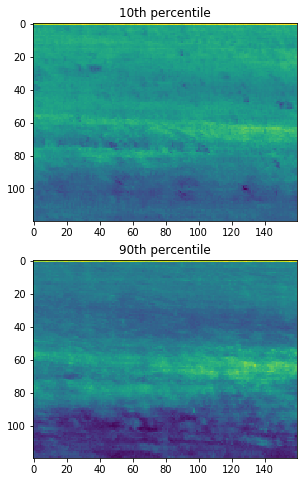

In [59]:
plt.close()
percentile_range = (10, 90)
perc_lower_img = np.percentile(video_array, percentile_range[0], axis=0)
perc_higher_img = np.percentile(video_array, percentile_range[1], axis=0)

fig=plt.figure(figsize=(8, 8))
fig.add_subplot(2, 1, 1)
plt.imshow(perc_lower_img)
plt.title('{0}th percentile'.format(percentile_range[0]))

fig.add_subplot(2, 1, 2)
plt.imshow(perc_higher_img)
plt.title('{0}th percentile'.format(percentile_range[1]))

plt.show()

In [87]:
def check_lower_higher(x):
    #check if pixel value lies between 10-90 quantiles
    threshold_img = (x<perc_lower_img) | (x>perc_higher_img)
    return skimage.measure.block_reduce(threshold_img, (2,2), np.mean)==1

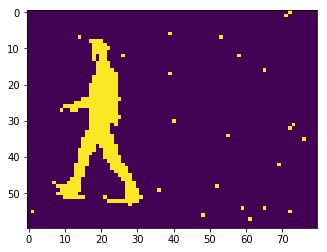

In [149]:
test_reduced = check_lower_higher(video_array[59])
plt.imshow(test_reduced)
plt.show()

In [89]:
test_reduced.shape

(60, 80)

In [98]:
def out_if_person(x):
    perc_out = float(x.sum())/(x.shape[0]*x.shape[1])
    return perc_out>0.01

In [99]:
out_if_person(test_reduced)

True

In [133]:
def get_com(x):
    'mass*distance/distance'
    y_c = np.dot(x.sum(axis=1),np.arange(x.shape[0]))/x.sum()
    x_c = np.dot(x.sum(axis=0),np.arange(x.shape[1]))/x.sum()
    return (y_c, x_c)

In [134]:
get_com(test_reduced)

(32.258152173913047, 21.766304347826086)

### Get bounding box based on sharpness of mass gradient along axis

In [174]:
def get_bounding_box(x):
    bound_range = x.shape
    
    x_ax = (x.sum(axis=0)>=4).astype(int)
    y_ax = (x.sum(axis=1)>=4).astype(int)
    
    kernel = np.array([1, 0, 1])
    
    #check neighbouring elements if True
    c_x_ax = convolve(x_ax, kernel, mode='constant')>=2
    c_y_ax = convolve(y_ax, kernel, mode='constant')>=2
    
    #find bounding box
    dot_x = np.nonzero(c_x_ax)[0]
    dot_y = np.nonzero(c_y_ax)[0]
    
    #boundary condition
    x_min = max(dot_x[0]-3, 0)
    x_max = min(dot_x[-1]+3, bound_range[1])
    y_min = max(dot_y[0]-3, 0)
    y_max = min(dot_y[-1]+3, bound_range[0])
    
    return (y_min, y_max, x_min, x_max)

In [175]:
get_bounding_box(test_reduced)

(6, 54, 7, 32)

In [167]:
a = (test_reduced.sum(axis=0)>=4).astype(int)
convolve(a, np.array([1,0,1]), mode='constant')>=2

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False], dtype=bool)

In [162]:
def check_lower_higher_1(x):
    #check if pixel value lies between 10-90 quantiles
    threshold_img = (x<perc_lower_img) | (x>perc_higher_img)
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    
    return convolve(threshold_img.astype(int), kernel, mode='constant')>=5
#     return threshold_img